In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as sp
import random
import anndata

In [2]:
def normalization(mtx):
    pf = mtx.sum(axis=1).A.ravel()
    log1p_pf = np.log1p(sp.sparse.diags(pf.mean()/pf) @ mtx)
    
    pf = log1p_pf.sum(axis=1).A.ravel()
    pf_log1p_pf = sp.sparse.diags(pf.mean()/pf) @ log1p_pf
    
    return pf_log1p_pf


In [3]:
adata = sc.read_mtx("../seurat/cortex_10x.mtx")
adata = adata.transpose()

obs = pd.read_csv("../seurat/cortex_10x_metadata.csv",index_col=[0])         
var = pd.read_csv("../ref/gene_display_table_expressed_7categories.csv")

X = adata.X
data = anndata.AnnData(X=X, obs=obs, var=var)    
data.var.set_index('gene_name', inplace=True)
data.X = normalization(data.X)
data.X = np.round_(data.X)

data.write("../seurat/cortex_10x.h5ad")

/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata = sc.read_mtx("../seurat/cortex_Parse.mtx")
adata = adata.transpose()

obs = pd.read_csv("../seurat/cortex_Parse_metadata.csv",index_col=[0])         
var = pd.read_csv("../ref/gene_display_table_expressed_7categories.csv")

X = adata.X
data = anndata.AnnData(X=X, obs=obs, var=var)    
data.var.set_index('gene_name', inplace=True)
data.X = normalization(data.X)
data.X = np.round_(data.X)

data.write("../seurat/cortex_Parse.h5ad")


## k vs n

In [ ]:
import Topyfic
import pandas as pd

k_topics = [15, 20, 25, 30, 35]

df = pd.DataFrame(columns=['k', 'N'])

for k in k_topics:
    top_model = Topyfic.read_topModel("../topyfic/10x/Cortex_" + str(k) + "/topModel_train_" + str(k) + ".p")
    tmp = pd.DataFrame([[k, top_model.N]], columns=['k', 'N'])
    df = pd.concat([df, tmp])
    


In [ ]:
df.to_csv('../topyfic/10x/k_vs_n.csv',index=False) 


## k vs n plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


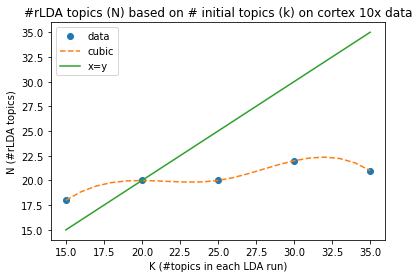

In [1]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

k_topics = [15, 20, 25, 30, 35]

df = pd.read_csv('../topyfic/10x/k_vs_n.csv') 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

x = df['k'].tolist()
y = df['N'].tolist()
xnew = np.linspace(15, 35, num=21, endpoint=True)

# Define interpolators.
f_linear = interp1d(x, y)
f_cubic = interp1d(x, y, kind='cubic')

plt.plot(x, y, 'o', label='data')
#plt.plot(xnew, f_linear(xnew), '-', label='linear')
plt.plot(xnew, f_cubic(xnew), '--', label='cubic')
plt.plot(k_topics, k_topics, linestyle='solid', label='x=y')
#plt.axvline(x=25, color="red", linestyle="solid", label='k=25')
plt.xlabel('K (#topics in each LDA run)')
plt.ylabel('N (#rLDA topics)')
plt.title(r"#rLDA topics (N) based on # initial topics (k) on cortex 10x data")
plt.legend(loc='best')


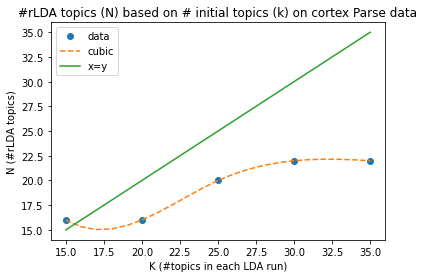

In [2]:
df = pd.read_csv('../topyfic/parse/k_vs_n.csv') 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

x = df['k'].tolist()
y = df['N'].tolist()
xnew = np.linspace(15, 35, num=21, endpoint=True)

# Define interpolators.
f_linear = interp1d(x, y)
f_cubic = interp1d(x, y, kind='cubic')

plt.plot(x, y, 'o', label='data')
#plt.plot(xnew, f_linear(xnew), '-', label='linear')
plt.plot(xnew, f_cubic(xnew), '--', label='cubic')
plt.plot(k_topics, k_topics, linestyle='solid', label='x=y')
#plt.axvline(x=25, color="red", linestyle="solid", label='k=25')
plt.xlabel('K (#topics in each LDA run)')
plt.ylabel('N (#rLDA topics)')
plt.title(r"#rLDA topics (N) based on # initial topics (k) on cortex Parse data")
plt.legend(loc='best')

# Combine

In [ ]:
import sys
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
import random

In [ ]:
tissue = "Cortex"
k = 20

data_parse = sc.read_h5ad("../seurat/cortex_Parse.h5ad")
data_parse = data_parse[data_parse.obs["tissue"] == tissue]

data_multiome = sc.read_h5ad("../seurat/cortex_10x.h5ad")
data_multiome = data_multiome[data_multiome.obs["tissue"] == tissue]

data = data_parse.concatenate(data_multiome)

In [ ]:
train_parse = Topyfic.read_train("../topyfic/parse/train_train_" + str(k) + ".p")
train_parse.name = "cortex_parse_20"
train_10x = Topyfic.read_train("../topyfic/10x/train_train_" + str(k) + ".p")
train_10x.name = "cortex_10x_20"


## create topmodel

In [ ]:
trains = [train_parse, train_10x]
top_model, clustering = Topyfic.calculate_leiden_clustering(trains=trains, 
                                                            data=data)

genes = pd.read_csv("../ref/gene_display_table_expressed_7categories.csv", index_col=0)

for key in top_model.topics.keys():
    top_model.topics[key].update_gene_information(genes)
    
clustering.to_csv("../topyfic/Cortex_parse_10x_20/cluster_contribution.csv")
top_model.save_topModel("../topyfic/Cortex_parse_10x_20/topModel_cortex_10x_20_cortex_parse_20")



## plots

In [ ]:
Topyfic.plot_cluster_contribution(clustering,
                              feature="assays",
                              file_format="png",
                              file_name='../topyfic/Cortex_parse_10x_20/figures/cluster_contribution')



## analysis

In [ ]:
top_model = Topyfic.read_topModel("../topyfic/Cortex_parse_10x_20/topModel_cortex_10x_20_cortex_parse_20.p")
analysis_top_model = Topyfic.Analysis(Top_model=top_model)
analysis_top_model.calculate_cell_participation(data=data)
analysis_top_model.save_analysis("../topyfic/Cortex_parse_10x_20/analysis_Cortex_10x_Cortex_parse")


In [ ]:
analysis_top_model = Topyfic.read_analysis("../topyfic/Cortex_parse_10x_20/analysis_Cortex_10x_Cortex_parse.p")


In [ ]:
label = dict()
for i in range(analysis_top_model.top_model.N):
    key = f"Topic_{i+1}"
    value = f"CX{i+1}"
    label[key] = value

analysis_top_model.average_cell_participation(label=label,
                                              color="orange",
                                              file_format='pdf',
                                              file_name="../topyfic/Cortex_parse_10x_20/figures/average_cell_participation")



In [ ]:
celltypes = data.obs.celltypes.unique().tolist()
for celltype in celltypes:
    subtypes = data.obs[data.obs.celltypes == celltype].subtypes.unique().tolist()
    file_name = "../topyfic/Cortex_parse_10x_20/figures/pieChart/dist_topics_celltypes_RNA_{celltype}"
    analysis_top_model.pie_structure_Chart(level='subtypes',
                                           category=subtypes,
                                            save=True,
                                            show=False,
                                            file_format='png',
                                            file_name=file_name)

subtypes = data.obs.subtypes.unique().tolist()
file_name = "../topyfic/Cortex_parse_10x_20/figures/pieChart/dist_topics_subtypes_RNA"
analysis_top_model.pie_structure_Chart(level='subtypes',
                                       category=subtypes,
                                       save=True,
                                       show=False,
                                       file_format='png',
                                       file_name=file_name)

In [ ]:
import matplotlib as mpl

my_palette_timepoint = {'PND_04': 'thistle',
                                 'PND_10': 'plum',
                                 'PND_14': 'violet',
                                 'PND_25': 'mediumorchid',
                                 'PND_36': 'darkviolet',
                                 'PNM_02': 'purple',
                                 'PNM_18': 'indigo'}

my_palette_sex = {'Female': 'pink',
                  'Male': 'blue'}

my_palette_tec = {'Parse': 'red',
                  '10x': 'green'}

my_palette = {'timepoint' : my_palette_timepoint,
              'sex': my_palette_sex,
              'technology': my_palette_tec}

In [ ]:
celltypes = data.obs.celltypes.unique().tolist()
for celltype in celltypes:
    subtypes = data.obs[data.obs.celltypes == celltype].subtypes.unique().tolist()
    file_name = "../topyfic/Cortex_parse_10x_20/figures/structurePlot/dist_topics_celltypes_RNA_timepoint_{celltype}"
    analysis_top_model.structure_plot(level='subtypes',
                                      category=subtypes, 
                                      metaData=["timepoint", "sex", "technology"],
                                      metaData_palette=my_palette,
                                      order_cells=["timepoint", "hierarchy"],
                                      save=True,
                                      show=False,
                                      file_format='png',
                                      file_name=file_name)

subtypes = data.obs.subtypes.unique().tolist()
file_name = "../topyfic/Cortex_parse_10x_20/figures/structurePlot/dist_topics_subtypes_RNA_timepoint_hierarchical"
analysis_top_model.structure_plot(level='subtypes',
                                  category=subtypes,
                                  metaData=["timepoint", "sex", "technology"],
                                  metaData_palette=my_palette,
                                  order_cells=["timepoint", "hierarchy"],
                                  save=True,
                                  show=False,
                                  file_format='png',
                                  file_name=file_name)

In [ ]:
metadata = ['celltypes']
analysis_top_model.TopicTraitRelationshipHeatmap(metadata,
                                                 save=True,
                                                 show=True,
                                                 file_format='png',
                                                 file_name='../topyfic/Cortex_parse_10x_20/figures/topic-traitRelationships_celltypes')

metadata = ['timepoint','celltypes','subtypes']
analysis_top_model.TopicTraitRelationshipHeatmap(metadata,
                                                 save=True,
                                                 show=True,
                                                 file_format='png',
                                                 file_name='../topyfic/Cortex_parse_10x_20/figures/topic-traitRelationships')

## gene weight

In [ ]:
top_model = Topyfic.read_topModel("../topyfic/Cortex_parse_10x_20/topModel_cortex_10x_20_cortex_parse_20.p")
gene_weights = top_model.get_gene_weights()
gene_weights.to_csv("../topyfic/Cortex_parse_10x_20/gene_weights.csv")
gene_weights